In [ ]:
# Step 1: Install Dependencies
!pip install transformers datasets scikit-learn matplotlib nltk

**Uploading the dataset it contains two columns Category and Text**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/equity research/train.csv')



Mounted at /content/drive


In [ ]:
df.head()

,Category,Text
0,Accountant,education omba executive leadership university...
1,Accountant,howard gerrard accountant deyjobcom birmingham...
2,Accountant,kevin frank senior accountant inforesumekraftc...
3,Accountant,place birth nationality olivia ogilvy accounta...
4,Accountant,stephen greet cpa senior accountant 9 year exp...


**Data Preprocessing
Lowercasing, stop-word removal, lemmatization
Encode labels**

In [ ]:
# Step 3: Preprocessing
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['Clean_Text'] = df['Text'].apply(preprocess)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


We're importing the NLTK library (Natural Language Toolkit), which is commonly used for text preprocessing.
nltk: A natural language processing (NLP) library.

re: Regular expressions module for pattern matching.

stopwords: Commonly used words in a language (like "the", "is") that are often removed from text.

WordNetLemmatizer: Used to reduce words to their base form (lemma), e.g., "running" → "run".

This code cleans text data by converting it to lowercase, removing non-alphabetic characters, and eliminating stopwords. It then lemmatizes the remaining words to their base form. Finally, it applies this cleaning process to a column in a DataFrame and stores the result in a new column.

**Label Encoding**

In [ ]:

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Encoded_Label'] = le.fit_transform(df['Category'])
num_labels = df['Encoded_Label'].nunique()

This code converts text labels in the 'Category' column into numbers using LabelEncoder, making them easier for machine learning models to understand. The new numeric labels are stored in a column called 'Encoded_Label'. It also counts how many unique labels are present using nunique().









**Before feeding our cleaned text into the BERT model, we need to convert it into a format BERT understands**

In [ ]:

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokens = tokenizer(
    list(df['Clean_Text']),
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

This code changes the cleaned text into a format that BERT can understand. It first loads a ready-to-use BERT tokenizer (bert-base-uncased) that breaks text into small word-pieces and makes everything lowercase. Then it processes all texts in the 'Clean_Text' column by:

Making all texts the same length (short ones are padded, long ones are cut at 128 words).

Turning the text into numbers that BERT can read.

Giving the result in PyTorch format to use with BERT models.

**Reducing Dataset Size to Save Time During Hyperparameter Tuning**

In [ ]:
# Step 6: Dataset and DataLoader
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class TextDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = tokens
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': self.tokens['input_ids'][idx],
            'attention_mask': self.tokens['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx])
        }

full_dataset = TextDataset(tokens, df['Encoded_Label'].tolist())
subset_size = int(0.2 * len(full_dataset))
subset, _ = random_split(full_dataset, [subset_size, len(full_dataset) - subset_size])

This code prepares a smaller dataset to speed up training and testing when trying different hyperparameter combinations (like learning rate, batch size, etc.), which can be computationally expensive.

A custom TextDataset class is created to hold tokenized text and labels, making it compatible with PyTorch models.

The full dataset is built from BERT tokens and their encoded labels.

Only 20% of the data is selected randomly using random_split() to form a smaller subset, reducing training time while still allowing meaningful model evaluation.

**Training and Evaluating a BERT Model**

In [ ]:
# Step 7: Hyperparameter tuning
from transformers import BertForSequenceClassification
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

def train_eval_model(lr, batch_size, epochs):
    train_size = int(0.8 * len(subset))   #Takes 80% of the subset for training and 20% for validation.
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size)  #Creates DataLoaders to feed data to the model in batches (train_dl and val_dl).

    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)  #Loads a pretrained BERT model for classification.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr)  #ets up the optimizer (AdamW) with the given learning rate.

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_dl:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_dl))

        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in val_dl:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                val_loss += outputs.loss.item()
                preds = torch.argmax(outputs.logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch['labels'].cpu().numpy())
        val_losses.append(val_loss / len(val_dl))

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return train_losses, val_losses, acc, prec, rec, f1

**Training Loop (for each epoch)**

Sets model to training mode.
Loops through training batches, computes the loss, does backpropagation, and
updates weights.
Tracks average training loss for the epoch.

**Validation Loop (after each epoch)**

Sets model to evaluation mode (no learning here).
Passes validation data without updating weights.
Calculates validation loss and stores model predictions and true labels.

**Accuracy**: how many predictions were correct

**Precision**: how accurate the positive predictions are

**Recall**: how well the model catches all correct positives

**F1-Score**: balance between precision and recall explain this with example

We are using adamW optimizer as AdamW helps the model learn faster and more smoothly by adjusting how much each part of the model updates during training. It works well for language tasks where not all words matter equally. It also helps prevent the model from overfitting, so it works better on new data.


**Run hyperparameter tuning**

We are testing model with different sets of hyperparameters learning rate=[1e-5, 3e-5] and batch size =[8,16] and testing its accuracy, precision, recall and f1 for every set we are keeping epoch as 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are

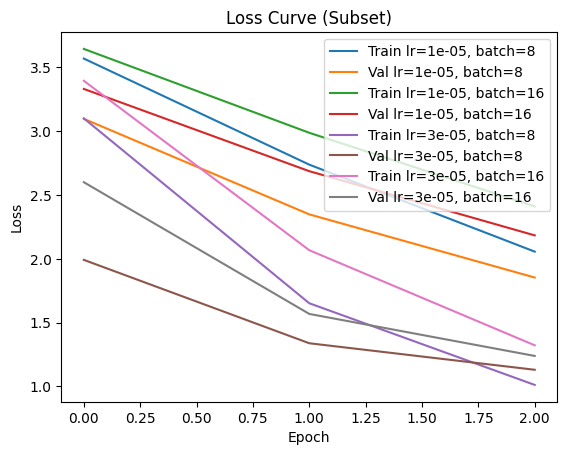

In [ ]:

results = []
for lr in [1e-5, 3e-5]:
    for batch in [8, 16]:
        train_losses, val_losses, acc, prec, rec, f1 = train_eval_model(lr, batch, epochs=3)
        results.append({
            'lr': lr, 'batch_size': batch, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1
        })
        plt.plot(train_losses, label=f'Train lr={lr}, batch={batch}')
        plt.plot(val_losses, label=f'Val lr={lr}, batch={batch}')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (Subset)")
plt.legend()
plt.show()

All curves show a decreasing loss, indicating the model is learning,Both training and validation losses reduce consistently over 3 epochs.
Best Performing Combo (lowest loss):

Train lr=3e-05, batch=8

Val lr=3e-05, batch=8

These curves reach the lowest loss values, indicating this combo learns best on both train and val sets.

Worst Performing Combo:

Train lr=1e-05, batch=16

Val lr=1e-05, batch=16

These show the slowest learning and highest loss.


In [ ]:
import pandas as pd

# Convert results list to a DataFrame
df_results = pd.DataFrame(results)

# Display the full table
print("All hyperparameter combinations and their evaluation metrics:")
print(df_results)

# Sort by F1 score to find the best configuration
best_config = df_results.sort_values(by="f1", ascending=False).head(1)
print("\nBest hyperparameter combination based on F1 score:")
print(best_config)


All hyperparameter combinations and their evaluation metrics:
        lr  batch_size  accuracy  precision    recall        f1
0  0.00001           8  0.649254   0.645924  0.649254  0.616462
1  0.00001          16  0.604478   0.625651  0.604478  0.558733
2  0.00003           8  0.755597   0.788073  0.755597  0.755168
3  0.00003          16  0.744403   0.763552  0.744403  0.735739

Best hyperparameter combination based on F1 score:
        lr  batch_size  accuracy  precision    recall        f1
2  0.00003           8  0.755597   0.788073  0.755597  0.755168


Comparing all combinations of lrs and batch sizes-accuracy, precision, recall and f1

**With the best combination that is lr 0.00003 and batch size 8 we are training the model with full dataset**

In [ ]:
# Train final model
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_config = max(results, key=lambda x: x['f1'])
print("Best config:", best_config)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size])
train_dl = DataLoader(train_ds, batch_size=best_config['batch_size'], shuffle=True)
val_dl = DataLoader(val_ds, batch_size=best_config['batch_size'])

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
model.to(device)
optimizer = AdamW(model.parameters(), lr=best_config['lr'])

train_losses, val_losses = [], []
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in train_dl:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_dl))

    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_dl:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())
    val_losses.append(val_loss / len(val_dl))

Best config: {'lr': 3e-05, 'batch_size': 8, 'accuracy': 0.7555970149253731, 'precision': 0.7880729179793061, 'recall': 0.7555970149253731, 'f1': 0.7551676285713057}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Final Accuracy: 0.7938760268857357
Final Precision: 0.8178940525183409
Final Recall: 0.7938760268857357
Final F1 Score: 0.794246126149929


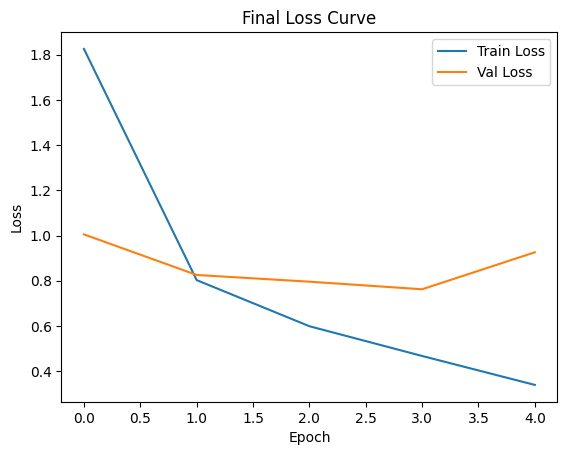

In [ ]:
# Save and evaluate
model.save_pretrained("final_bert_model")
tokenizer.save_pretrained("final_bert_model")

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Final Accuracy:", accuracy_score(all_labels, all_preds))
print("Final Precision:", precision_score(all_labels, all_preds, average='weighted', zero_division=0))
print("Final Recall:", recall_score(all_labels, all_preds, average='weighted', zero_division=0))
print("Final F1 Score:", f1_score(all_labels, all_preds, average='weighted', zero_division=0))

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Final Loss Curve")
plt.legend()
plt.show()

Training Loss (blue) steadily decreases from 1.8 to 0.35 over 5 epochs indicates the model is learning well on the training data.

Validation Loss (orange) decreases initially (till epoch 2), but starts increasing after epoch 3 this is a classic sign of overfitting.

We can see that val loss is increasing after epoch 3 which is making model slight overfit so it is better to use epoch 3 instead of epoch 5 to train the model